In [35]:
import pandas as pd, re, unicodedata
from collections import Counter
import spacy, re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random

In [2]:
legal_data_path = r".\Datos\sentencias_pasadas.xlsx"

In [3]:
legal_data = pd.read_excel(legal_data_path)

In [4]:
legal_data.head(5)

,#,Relevancia,Providencia,Tipo,Fecha Sentencia,Tema - subtema,resuelve,sintesis
0,1,966965.0,T-185/22,NaN,2022-05-31,NaN,en nombre del pueblo y por mandato de la Const...,En este caso se formula la acción de tutela en...
1,3,963168.0,T-356/21,NaN,2021-10-15,ACCIÓN DE TUTELA PARA PROTEGER EL DERECHO A LA...,en nombre del pueblo y por mandato de la Const...,El peticionario considera que los accionantes ...
2,5,956201.0,T-351/22,NaN,2022-10-07,ACCIÓN DE TUTELA PARA PROTEGER EL DERECHO A LA...,"administrando justicia en nombre del Pueblo, y...",El periodista accionante acusa al abogado acci...
3,6,955889.0,T-246/21,NaN,2021-07-29,ACCION DE TUTELA PARA PROTEGER EL DERECHO A LA...,en nombre del pueblo y por mandato de la Const...,Se presenta la acción de tutela en contra de u...
4,7,955787.0,T-245A/22,NaN,2022-07-01,ACCION DE TUTELA-Inexistencia de hecho superad...,en nombre del pueblo y por mandato de la Const...,"El accionante, actuando en representación de s..."


In [5]:
# !pip install wordcloud

In [6]:
# ── carga modelo spaCy (ya instalado) ─────────────────────────────────────
nlp = spacy.load("es_core_news_sm", disable=["ner"])  # lematizador + tagger bastan

# ── stop-words (spaCy + extras) ───────────────────────────────────────────
STOP = nlp.Defaults.stop_words

# ── expresión para tokens alfanuméricos ───────────────────────────────────
TOKEN_RE = re.compile(r"\b\w+\b", re.UNICODE)

def clean_lemmas(doc):
    """Devuelve lemas filtrados y en minúsculas para un spaCy Doc."""
    return [
        tok.lemma_.lower()
        for tok in doc
        if tok.is_alpha                       # solo letras
           and tok.lemma_.lower() not in STOP
    ]

# ── frecuencia global de lemas ────────────────────────────────────────────
all_lemmas = (
    lemma
    for doc in nlp.pipe(legal_data["sintesis"].astype(str), batch_size=256)
    for lemma in clean_lemmas(doc)
)
counts = Counter(all_lemmas)                      # {lemma: frecuencia}

# ── DataFrame ordenado (por si lo necesitas) ──────────────────────────────
freq_df = (
    pd.DataFrame(counts.items(), columns=["lemma", "count"])
      .sort_values("count", ascending=False)
      .reset_index(drop=True)
)

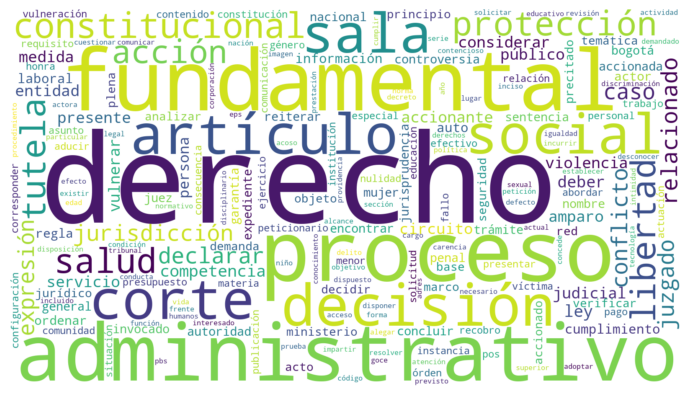

In [7]:
# ── Word-cloud (“sopa de palabras”) ───────────────────────────────────────
wc = WordCloud(
        width=1600, height=900,
        background_color="white",
        colormap="viridis",
        prefer_horizontal=0.9,
        normalize_plurals=False
    ).generate_from_frequencies(counts)

plt.figure(figsize=(7, 5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
plt.show()

In [8]:
freq_df.to_csv(
    "frecuencias_globales.csv",
    index=False,
    encoding="utf-8-sig"     # ← UTF-8 + BOM para máxima compatibilidad
)

## "Hay muchos tipos de demandas, por esto, para la prueba, quieren concentrarse en demandas relacionadas a redes sociales."

In [10]:
# ── 1. lista de frases tema + sinónimos ───────────────────────────────────
# TOPIC = [
#     "red social",
#     "plataforma social",
#     "medio social",  "medios sociales",
#     "comunidad en línea", "comunidad virtual",
#     "plataforma de interacción",
#     "facebook", "instagram"
# ]

# ── TOPIC: cobertura amplia de “redes sociales” y sus variantes ───────────
TOPIC = [
    # ── genéricos en español ──────────────────────────────────────────────
    "red social", "redes sociales",
    "plataforma social", "plataformas sociales",
    "plataforma de medios sociales", "plataformas de medios sociales",
    "medio social", "medios sociales",
    "plataforma de interacción", "plataformas de interacción",
    "comunidad en línea", "comunidades en línea",
    "comunidad virtual", "comunidades virtuales",
    "plataforma digital", "plataformas digitales",
    "sitio de redes sociales", "sitios de redes sociales",
    "servicio de microblogging", "microblogging",

    # ── plataformas principales (castellano / inglés) ─────────────────────
    "facebook", "meta",
    "instagram", "threads",
    "twitter", "x", "tweet", "tweets",
    "snapchat", "tiktok", "linkedin", "youtube", "yt", "reddit",
    "pinterest", "whatsapp", "wa", "telegram", "discord", "tumblr",
    "vimeo", "flickr", "wechat", "line", "kakao", "weibo",

    # ── otros términos de uso frecuente ───────────────────────────────────
    "red social corporativa",
    "foro en línea", "foros en línea",
    "plataforma de networking",
    "plataforma colaborativa",
]

# ── 2. helper para quitar tildes y pasar a minúsculas ─────────────────────
def strip_accents(txt: str) -> str:
    return ''.join(
        c for c in unicodedata.normalize("NFD", txt.lower())
        if unicodedata.category(c) != "Mn"        # elimina marcas diacríticas
    )

# ── 3. compilar patrón regex (acentos ya eliminados) ─────────────────────
synonyms_norm = [strip_accents(s) for s in TOPIC]
pattern      = re.compile(r"\b(" + "|".join(map(re.escape, synonyms_norm)) + r")\b")

# ── 4. máscara booleana → filas cuyo “sintesis” incluye algún sinónimo ───
mask = legal_data["sintesis"].astype(str).apply(
    lambda txt: bool(pattern.search(strip_accents(txt)))
)

filtered = legal_data.loc[mask].copy().reset_index(drop=True)         # ← DataFrame filtrado
dropped  = len(legal_data) - len(filtered)

# ── 5. reporte rápido (opcional) ──────────────────────────────────────────
print(f"Filas retenidas: {len(filtered)}  ·  Filas excluidas: {dropped}")

Filas retenidas: 51  ·  Filas excluidas: 278


In [11]:
filtered.head(3)

,#,Relevancia,Providencia,Tipo,Fecha Sentencia,Tema - subtema,resuelve,sintesis
0,1,966965.0,T-185/22,NaN,2022-05-31,NaN,en nombre del pueblo y por mandato de la Const...,En este caso se formula la acción de tutela en...
1,3,963168.0,T-356/21,NaN,2021-10-15,ACCIÓN DE TUTELA PARA PROTEGER EL DERECHO A LA...,en nombre del pueblo y por mandato de la Const...,El peticionario considera que los accionantes ...
2,5,956201.0,T-351/22,NaN,2022-10-07,ACCIÓN DE TUTELA PARA PROTEGER EL DERECHO A LA...,"administrando justicia en nombre del Pueblo, y...",El periodista accionante acusa al abogado acci...


In [12]:
filtered.to_excel("legal_data_filtrado.xlsx", index=False)

In [13]:
# ── frecuencia global de lemas ────────────────────────────────────────────
all_lemmas = (
    lemma
    for doc in nlp.pipe(filtered["sintesis"].astype(str), batch_size=256)
    for lemma in clean_lemmas(doc)
)
counts = Counter(all_lemmas)                      # {lemma: frecuencia}

# ── DataFrame ordenado (por si lo necesitas) ──────────────────────────────
freq_df = (
    pd.DataFrame(counts.items(), columns=["lemma", "count"])
      .sort_values("count", ascending=False)
      .reset_index(drop=True)
)

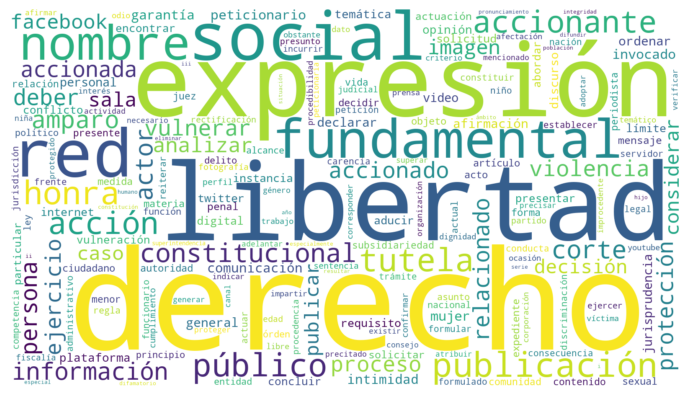

In [14]:
# ── Word-cloud (“sopa de palabras”) ───────────────────────────────────────
wc = WordCloud(
        width=1600, height=900,
        background_color="white",
        colormap="viridis",
        prefer_horizontal=0.9,
        normalize_plurals=False
    ).generate_from_frequencies(counts)

plt.figure(figsize=(7, 5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
plt.show()

In [31]:
filtered

,#,Relevancia,Providencia,Tipo,Fecha Sentencia,Tema - subtema,resuelve,sintesis
0,1,966965.00,T-185/22,NaN,2022-05-31,NaN,en nombre del pueblo y por mandato de la Const...,En este caso se formula la acción de tutela en...
1,3,963168.00,T-356/21,NaN,2021-10-15,ACCIÓN DE TUTELA PARA PROTEGER EL DERECHO A LA...,en nombre del pueblo y por mandato de la Const...,El peticionario considera que los accionantes ...
2,5,956201.00,T-351/22,NaN,2022-10-07,ACCIÓN DE TUTELA PARA PROTEGER EL DERECHO A LA...,"administrando justicia en nombre del Pueblo, y...",El periodista accionante acusa al abogado acci...
3,6,955889.00,T-246/21,NaN,2021-07-29,ACCION DE TUTELA PARA PROTEGER EL DERECHO A LA...,en nombre del pueblo y por mandato de la Const...,Se presenta la acción de tutela en contra de u...
4,7,955787.00,T-245A/22,NaN,2022-07-01,ACCION DE TUTELA-Inexistencia de hecho superad...,en nombre del pueblo y por mandato de la Const...,"El accionante, actuando en representación de s..."
5,8,954029.00,T-190/24,NaN,2024-05-23,NaN,RESUELVE PRIMERO. CONFIRMAR la decisión profer...,El actor solicitó la protección de los derecho...
6,9,947406.00,T-394/24,NaN,2024-09-19,NaN,RESUELVE PRIMERO. CONFIRMAR la Sentencia del 1...,La presente acción de tutela fue formulada por...
7,10,945053.00,T-155/19,NaN,2019-04-04,DERECHO A LA INTIMIDAD-Alcance y contenido DER...,en nombre del pueblo y por mandato de la Const...,"En el presente caso, se atribuye la vulneració..."
8,11,943156.00,T-339/22,NaN,2022-09-28,CARENCIA ACTUAL DE OBJETO POR DAÑO CONSUMADO-D...,en nombre del pueblo y por mandato de la Const...,La actora adujo que la persona accionada vulne...
9,14,939.17,T-281/21,NaN,2021-08-23,ACCION DE TUTELA CONTRA PARTICULARES-Solicitud...,en nombre del pueblo y por mandato de la Const...,En este caso se instauró la acción de tutela b...


In [37]:
rand_idx = random.randrange(len(filtered))

In [39]:
rand_idx

45